In [2]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# 将当前工作目录添加到 Python 路径
# 获取当前工作目录
current_working_dir = os.getcwd()

# 将根目录添加到 sys.path
sys.path.append(os.path.abspath(os.path.join(current_working_dir, '../..')))

from function import metrics_to_dataframe, plot_actual_vs_predicted

In [3]:
# 读取数据
df = pd.read_csv('../dataset_removed_outliers_z.csv')

# 对指定列进行独热编码
columns_to_encode = ['CM_type', 'CM_morph', 'MS2_morph', 'CP_morph', 'Cation', 'Anion']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [4]:
# X = df_encoded.drop(['Cs'], axis=1)
# y = df_encoded['Cs']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=21
# )

from function import split_data

X_train, X_test, y_train, y_test = split_data(df_encoded, 'Cs')

In [5]:
# optuna 自动搜索超参数
import optuna
def objective(trial):
    param = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2025-03-07 00:17:29,572] A new study created in memory with name: no-name-508414b5-cf72-4eec-90e6-4c5bb415be0a
[I 2025-03-07 00:17:29,807] Trial 0 finished with value: 30.58131718600636 and parameters: {'learning_rate': 0.19475153244379712, 'subsample': 0.5310527847933005, 'gamma': 0.4262126506264836, 'max_depth': 16, 'min_child_weight': 5, 'reg_alpha': 0.3187454845008917, 'colsample_bytree': 0.6608568654157093, 'colsample_bylevel': 0.6540101330481616, 'colsample_bynode': 0.6246598525449177}. Best is trial 0 with value: 30.58131718600636.
[I 2025-03-07 00:17:30,035] Trial 1 finished with value: 45.525751320454944 and parameters: {'learning_rate': 0.12251373220698367, 'subsample': 0.15845041035194185, 'gamma': 0.1313775549166427, 'max_depth': 18, 'min_child_weight': 1, 'reg_alpha': 0.6763836212305847, 'colsample_bytree': 0.6051775499022987, 'colsample_bylevel': 0.6139169055754652, 'colsample_bynode': 0.8130494984953336}. Best is trial 0 with value: 30.58131718600636.
[I 2025-03-07 00

Best trial:
  Value: 7.144854877904507
  Params: 
    learning_rate: 0.04961744239876421
    subsample: 0.7272982879134865
    gamma: 0.11657866701061625
    max_depth: 11
    min_child_weight: 6
    reg_alpha: 0.2537209471435358
    colsample_bytree: 0.9909944921682353
    colsample_bylevel: 0.9766573117164993
    colsample_bynode: 0.963925079542717


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


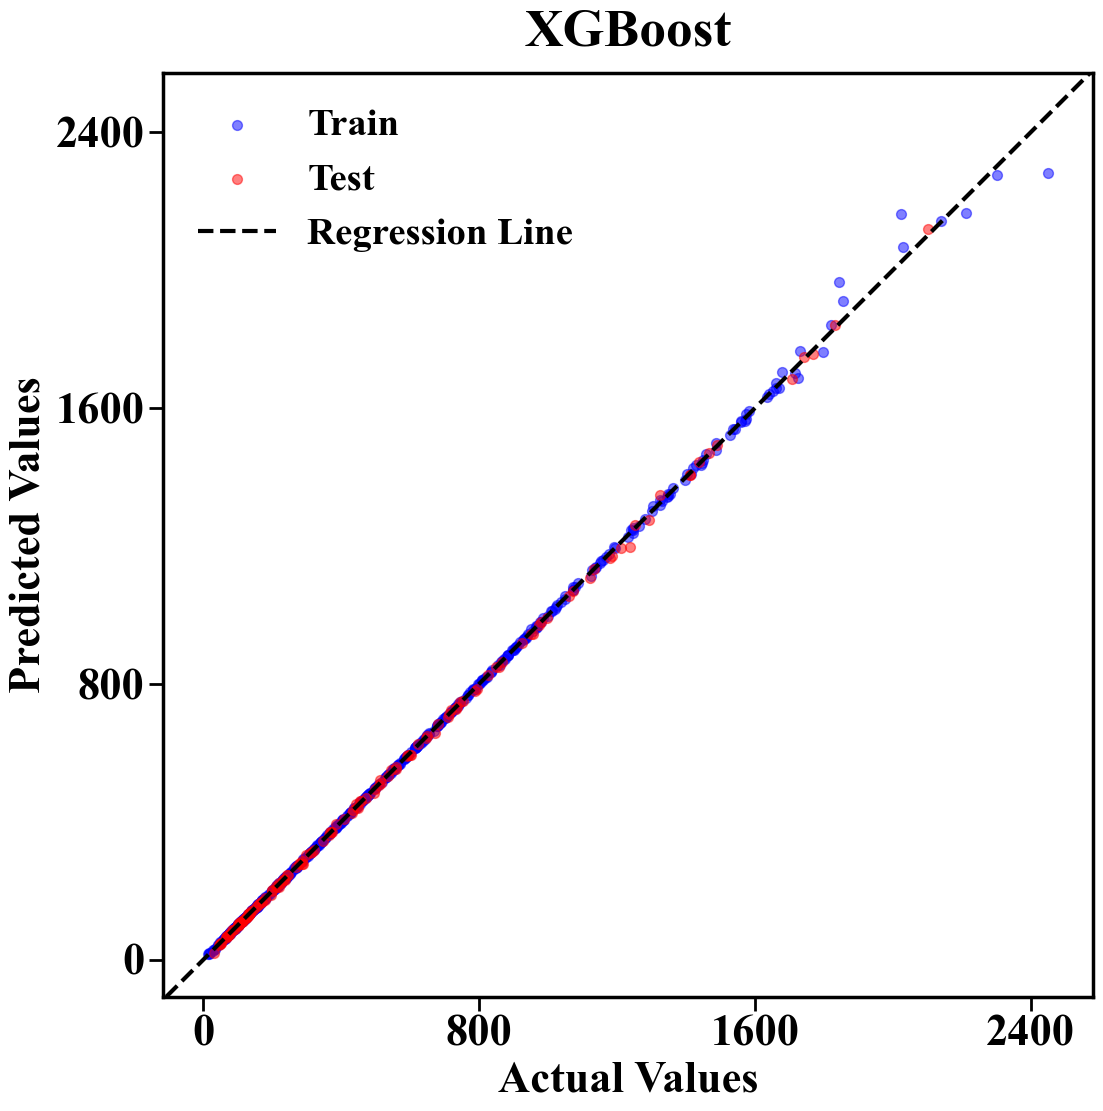

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,1.0,2.52,0.51,11.71,1.0,4.37,1.27,7.14


In [6]:
# 使用最佳参数训练模型
xgb_params = {
    'n_estimators': 300,
    'learning_rate': trial.params['learning_rate'],
    'subsample': trial.params['subsample'],
    'gamma': trial.params['gamma'],
    'max_depth': trial.params['max_depth'],
    'min_child_weight': trial.params['min_child_weight'],
    'reg_alpha': trial.params['reg_alpha'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'colsample_bylevel': trial.params['colsample_bylevel'],
    'colsample_bynode': trial.params['colsample_bynode'],    
}
model = XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost', figpath='xgb_actual_vs_predicted.png')
xgb_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost').round(2)
xgb_metrics